# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.742907,True,5.548482
1,-0.578994,True,3.978631
2,1.083485,True,5.150893
3,1.825167,True,5.792097
4,0.412343,False,1.715940
...,...,...,...
995,0.457370,True,4.309971
996,1.262566,True,6.610417
997,-0.423819,False,0.627554
998,1.845026,True,6.441792


<Axes: xlabel='v0'>

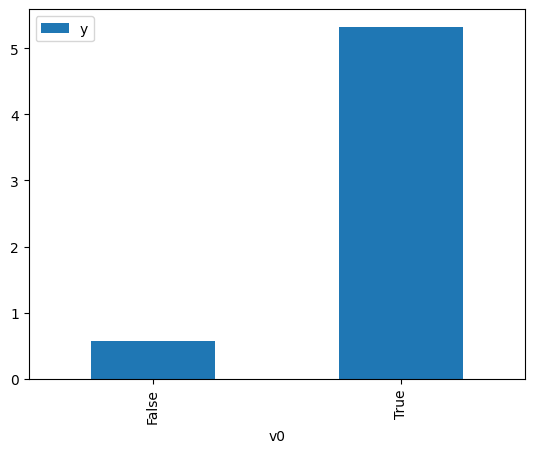

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

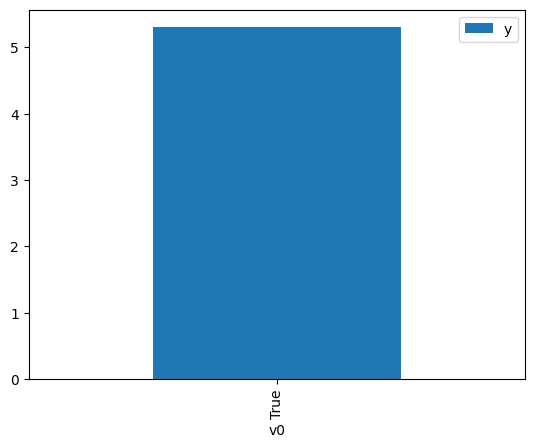

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,2.767089,False,2.060565,0.014798,67.578123
1,-1.129012,False,-1.747257,0.843427,1.185638
2,0.314696,False,-0.992390,0.378539,2.641736
3,0.209535,False,-0.095910,0.416543,2.400714
4,0.420335,False,0.472654,0.341808,2.925621
...,...,...,...,...,...
995,1.369470,False,0.529316,0.110244,9.070786
996,2.558555,False,3.192225,0.020163,49.595492
997,1.763665,False,2.752253,0.063960,15.634859
998,-1.816281,False,-0.227931,0.938289,1.065770


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.215822,True,4.095807,0.140032,7.141200
1,1.841199,True,6.864446,0.942701,1.060782
2,-0.081652,True,4.426283,0.474360,2.108105
3,1.312408,True,5.930213,0.881017,1.135051
4,1.532552,True,5.552142,0.911692,1.096862
...,...,...,...,...,...
995,-1.108822,True,3.389748,0.160640,6.225089
996,-0.988677,True,6.746436,0.186627,5.358278
997,1.859752,True,6.619564,0.944195,1.059103
998,-0.988677,True,6.746436,0.186627,5.358278


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.956
Model:                            OLS   Adj. R-squared (uncentered):              0.956
Method:                 Least Squares   F-statistic:                          1.075e+04
Date:                Fri, 01 Dec 2023   Prob (F-statistic):                        0.00
Time:                        15:08:14   Log-Likelihood:                         -1388.7
No. Observations:                1000   AIC:                                      2781.
Df Residuals:                     998   BIC:                                      2791.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9712      0.036     27.106      0.000       0.901       1.041
x2             4.9918      0.049    102.659      0.000       4.896       5.087
==============================================================================
Omnibus:                        1.619   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.445   Jarque-Bera (JB):                1.693
Skew:                           0.082   Prob(JB):                        0.429
Kurtosis:                       2.883   Cond. No.                         2.07
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""